# Основы машинного обучения

## Задача

Для разработки стратегии взаимодействия с клиентами (предупреждения или прогнозирования оттока) на основе аналитических данных в электронный вид переведено множество клиентских анкет. Задача — провести анализ с учетом специфики отрасли и подготовить план действий  по удержанию клиентов.  
А именно: 
* спрогнозировать вероятность оттока (на уровне следующего месяца);
* сформировать типичные портреты клиентов: 
    - выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        * выделить целевые группы клиентов;
        * предложить меры по снижению оттока;
        * определить другие особенности взаимодействия с клиентами.

- Исследование пройдет в несколько этпов:
    - Обзор данных.
    - Предобработка данных.
    - Исследовательский анализ данных (EDA).
    - Построение модели прогнозирования оттока клиентов
    - Кластеризация и кластерный анализ клиентов
    - Вывод и рекомендации.

## Обзор и предобработка данных

In [1]:
import os # импорт библиотек
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [2]:
pd.options.display.float_format = '{:,.2f}'.format  # изменение опции показа числовых данных

In [3]:
if os.path.exists('/datasets/gym_churn.csv'):   # чтение файлов с данными
    gym = pd.read_csv('/datasets/gym_churn.csv')
else:
    gym = pd.read_csv('gym_churn.csv')
gym

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0


In [4]:
gym.info()  # получение общей информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

### Описание данных:
      
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
    
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
      
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

Данные содержат данные на месяц до оттока и факт оттока на определённый месяц. Пропусков в данных нет.  Необходимо изменить регистр названия столбцов.

In [5]:
gym.columns = gym.columns.str.lower()  # приведение названия столбцов к нормальному виду
gym

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0


## Исследовательский анализ данных (EDA) 

In [6]:
gym.duplicated().sum() # проверка на дубликаты

0

In [7]:
gym.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Явных дубликатов не вывлено. Часть данных записана в бинарной классификации (да/нет; пол: м/ж)

* гедерное распределение почти равное
* большинство живут поблизости 
* половина клиентов - сотрудники компаний-партнеров
* около 30% клиентов приходят по промо-акциям
* поччти все оставляют контактные телефоны при регистрации
* 50% заключают контракт на 1 месяц, осташиеся - 25% на год и 25%  на 6 месяцев, соответвенно в тех же пропорциях и срок до докончания контракта 
* чуть меньше половины посещают групповые занятия
* возрст -  от 18 до 41 года, в среднем около 30лет
* на дополнительные услуги в месяц тратят в основном до 200 тугриков
* но больше половины с клубом уже больше квартала, это хорошо, значит продлевают месячные абонементы. Макимальное значение - 31 месяц... это почти 3 года постоянных отношений...
* средняя частота посещений за предыдущий месяц и за всё время посещений - почти одинакова - редко больше 2,5 раз в недлею... те колеблется от 2 до 3 раз в неделю.. хороший уровень.

* около трети клиентов фитнес-центра уходит в отток.

In [8]:
corr = gym.corr()
corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


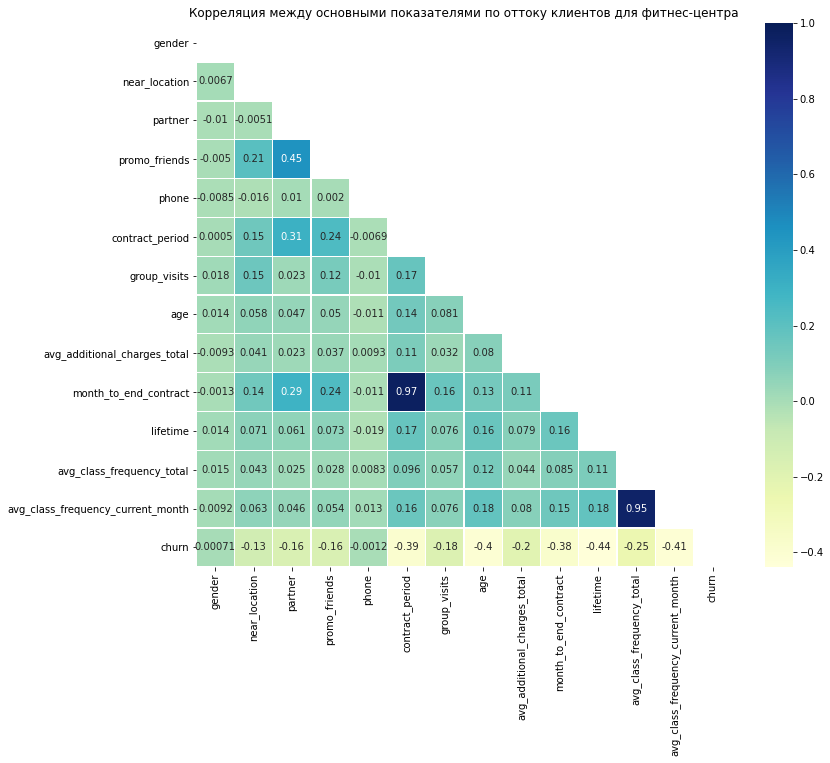

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
plt.title("Корреляция между основными показателями по оттоку клиентов для фитнес-центра")
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, vmax=1, linewidths=.3, annot=True ,cmap='YlGnBu', mask=mask, ax=ax)
plt.show()

Матрица корреляции определила 2 пары слишком коррелирущих значений. Скорее всего для построения корректой модели обучения нужно будет избавится от части данных. Остальные признаки допустимо использовать в модели машинного обучения

In [10]:
gym.groupby(['churn']).mean().transpose()

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Средние значения в группах позволяют опредилить "типового" клиента из тех кто остается и тех кто в зоне риска.

Посмотри на графическое представление распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

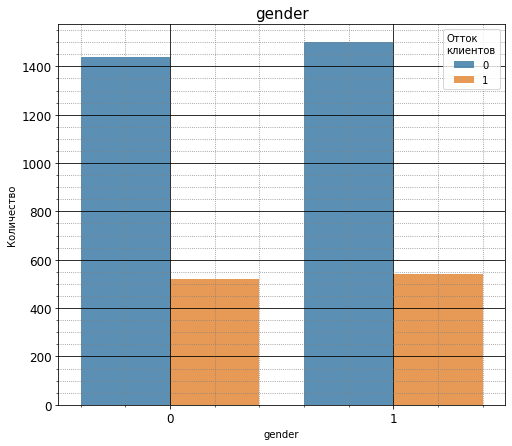

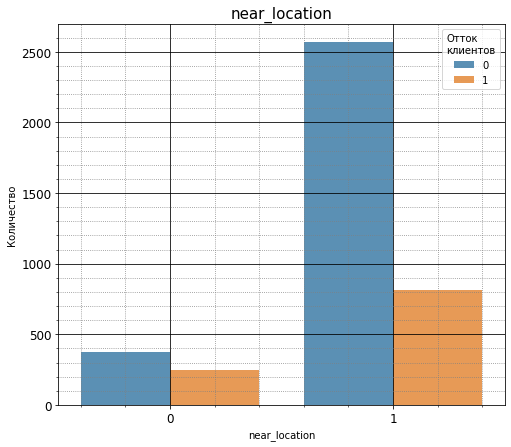

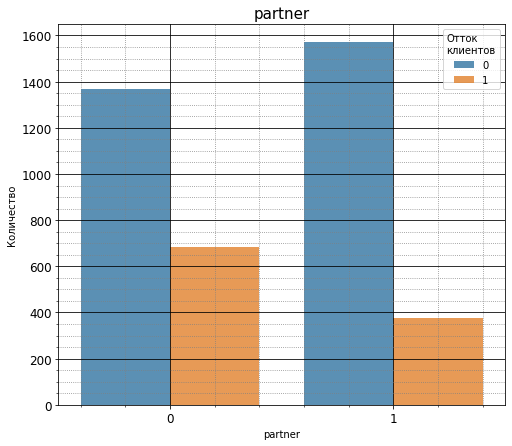

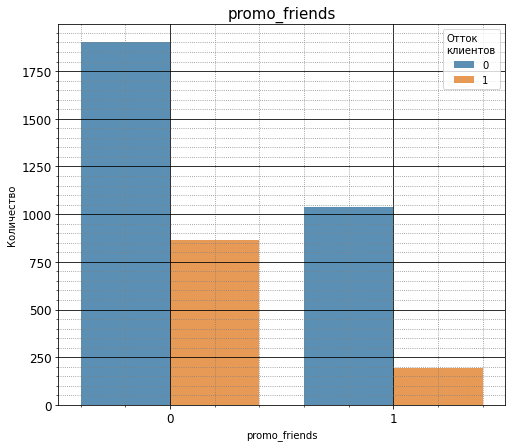

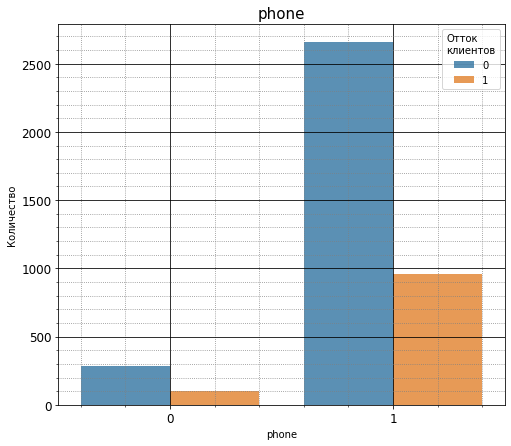

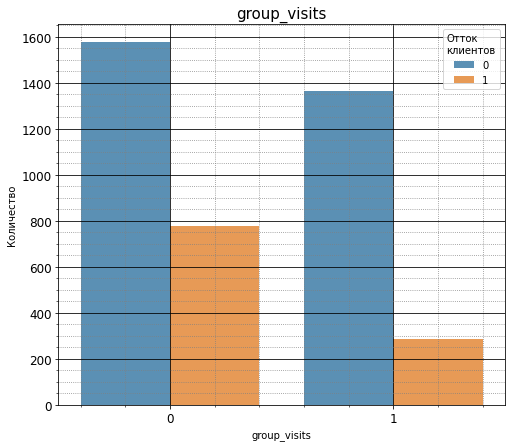

In [11]:
# разделяем датасет на бинарные признаки и признаки с бОльшим количеством переменных
for feature in gym.drop('churn', axis =1): 
    if gym[feature].nunique() < 3:
        plt.figure(figsize=(8,7)) # строим график
        sns.countplot(data = gym, x = gym[feature], hue = 'churn',alpha=0.8) 
        plt.ylabel('Количество')
        plt.xlabel(feature)
        plt.title(feature,fontsize=15)
        plt.grid(which='major',color = 'k')
        plt.minorticks_on()
        plt.grid(which='minor',color = 'gray',linestyle = ':')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Отток\nклиентов')
        plt.show()

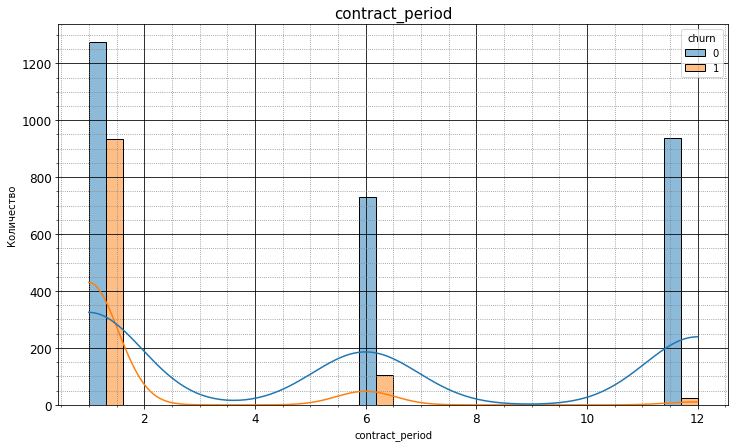

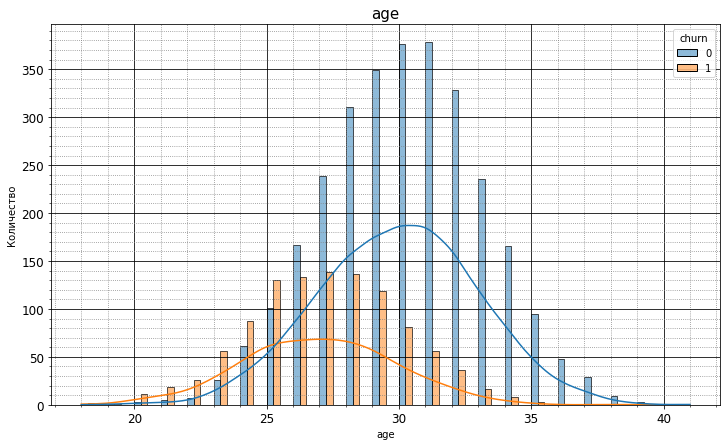

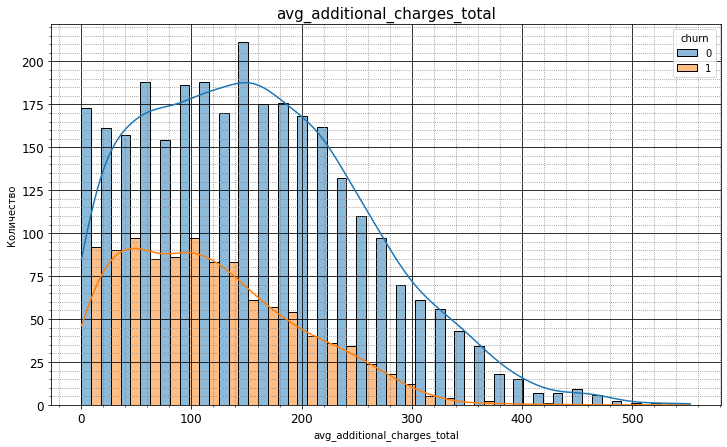

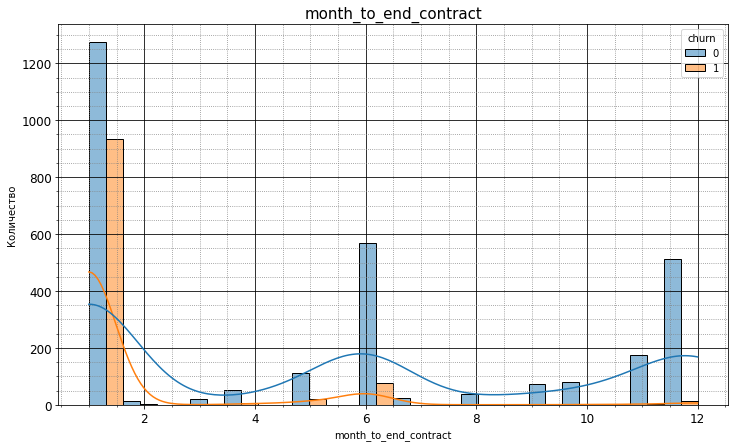

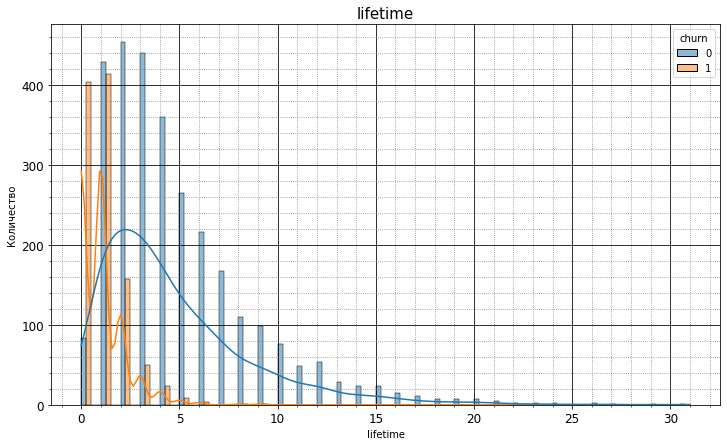

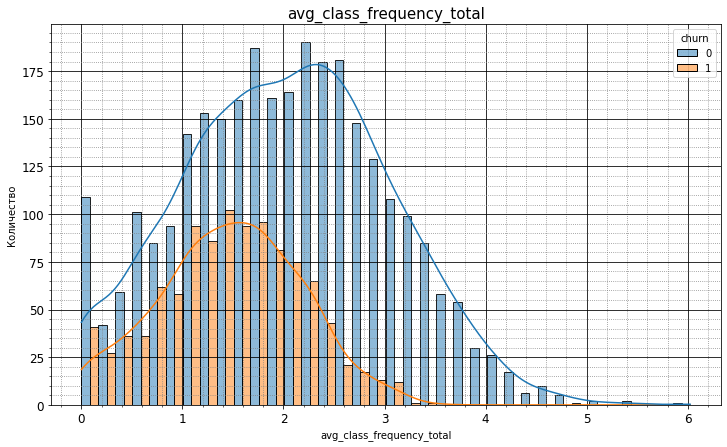

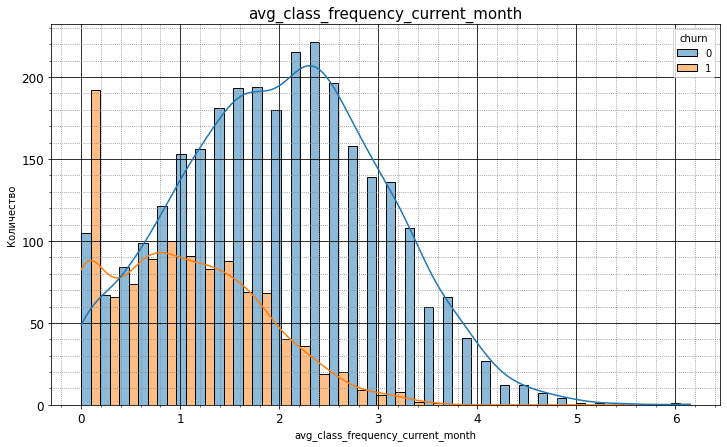

In [12]:
for feature in gym.drop('churn', axis =1):
    if gym[feature].nunique() > 2:
        plt.figure(figsize=(12,7))
        sns.histplot(data=gym, x = gym[feature], hue = 'churn',kde=True, multiple="dodge",  cbar= True)
        plt.ylabel('Количество')
        plt.grid(which='major',color = 'k')
        plt.minorticks_on()
        plt.grid(which='minor',color = 'gray',linestyle = ':')
        plt.xlabel(feature)
        plt.title(feature,fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    plt.show()   

### Предварительный вывод

Явных дубликатов не вывлено. Часть данных записана в бинарной классификации. Матрица корреляции определила 2 пары слишком коррелирущих значений. 

По визуальному распредлеению признаков можно предварительно говорить о следующем:
* пол - отток почти одинаковый . Примерно по 1/4 клиентов.
* near_location - проживание или работа в районе, где находится фитнес-центр существено увеличивает шансы что клиент останется 
* partner — если клиент - сотрудник компании-партнёра клуба, то вероятность остаться клиентом примерно 3/4, в противном случае уже ~ 2/3
* promo_friends - если пришёл заниматься "по дружбе", то очень вероятно что в останешься с клубом и в следующем месяце
* phone - только около 1/4 из тех клиентов, ктооставил контактный телефон уходил в течении следующего месяца.
* group_visits - факт посещения групповых занятий очень стимулиреут продолжать тренировки
* contract_period — длительность текущего действующего абонемента: раз уж купил аббонемент на год , то надо "выходить"  
* age - 29-32 года - самые надежные клиенты.
* avg_additional_charges_total - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон...если вам всё нравится в доп услугах и вы тратите на них дополнительно, то с большей вероятностьбю вы не покинете этот клуб в следующем месяце 
* month_to_end_contract  — срок до окончания текущего действующего абонемента (в месяцах), а вот если этот месяц в аббонементе последний, то шансов продлить его на следующий период уже не намного больше чем расстаться
* lifetime — время с момента первого обращения в фитнес-центр (в месяцах).Если вы с клубом не расстались за первые два месяца, то администрация уже может почти навереняка рассчитывать на вас как минимум на пол-года, а то и больше
* avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента. те кто ходит в среднем меньше 2х раз в неделю вероятно подумывает о прекращении занятий... 
* avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц, то же самое можно сказать и о посещениях в разрезе предыдущего месяца.


* гедерное распределение почти равное
* большинство живут поблизости 
* половина клиентов - сотрудники компаний-партнеров
* около 30% клиентов приходят по промо-акциям
* поччти все оставляют контактные телефоны при регистрации
* 50% заключают контракт на 1 месяц, осташиеся - 25% на год и 25%  на 6 месяцев, соответвенно в тех же пропорциях и срок до докончания контракта 
* чуть меньше половины посещают групповые занятия
* возрст -  от 18 до 41 года, в среднем около 30лет
* на дополнительные услуги в месяц тратят в основном до 200 тугриков
* но больше половины с клубом уже больше квартала, это хорошо, значит продлевают месячные абонементы. Макимальное значение - 31 месяц... это почти 3 года постоянных отношений...
* средняя частота посещений за предыдущий месяц и за всё время посещений - почти одинакова - редко больше 2,5 раз в недлею... те колеблется от 2 до 3 раз в неделю.. хороший уровень.

* около трети клиентов фитнес-центра уходит в отток.

## Модель прогнозирования оттока клиентов

Пострим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

Тля корректоного обучения модели уберем слишком сильно коррелирующие признаки

In [13]:
gym_model = gym.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
x = gym_model.drop(columns=['churn'], axis = 1)
y = gym_model['churn']

In [15]:
# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

In [16]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(x_train)
# Преобразование обучающего и валидационного набора данных
X_train_st = scaler.transform(x_train)
X_test_st = scaler.transform(x_test)

Обучим модель на train-выборке двумя способами:
* логистической регрессией,
* случайным лесом.

In [17]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)] # задаем список моделей

Чуть ли не самое важное при выборе модели - оценка метрик. Возьмем для этого такие метрики как  
* accuracy (Доля правильных ответов), 
* precision (Точность), 
* recall (полнота) и 
* ROC_AUC (площадь под кривой ошибок)   

для обеих моделей на валидационной выборке. 

<font size =6>
$\mathcal{Accuracy} = \left(\frac{TP+TN}{TP + TN+ FP+ FN}\right)$
     </font>

<font size =6>
$\mathcal{Precision} = \left(\frac{TP}{TP + FP}\right)$
     </font>

<font size =6>    
$\mathcal{Recall} =\left(\frac{TP}{TP + FN}\right)$
 </font>

In [18]:
 # функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train_st, y_test):
    model = m
    # обучим модель
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    print('Метрики при автоматическом прогнозе')
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))
    print ('*'*20)

In [19]:
#цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_test)

LogisticRegression(random_state=0)
Метрики при автоматическом прогнозе
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
ROC_AUC: 0.95
********************
RandomForestClassifier(random_state=0)
Метрики при автоматическом прогнозе
Accuracy: 0.89
Precision: 0.79
Recall: 0.76
ROC_AUC: 0.94
********************


### Предварительный вывод

При построении модели мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса.
Обе модели хорошо себя зарекомендовали на метрических тестах. Но логистическая регрессия все же оказалась лучше. Особенно по  доле положительных объектов выборки, распознанных моделью. 

## Кластеризация клиентов

In [20]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(x)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

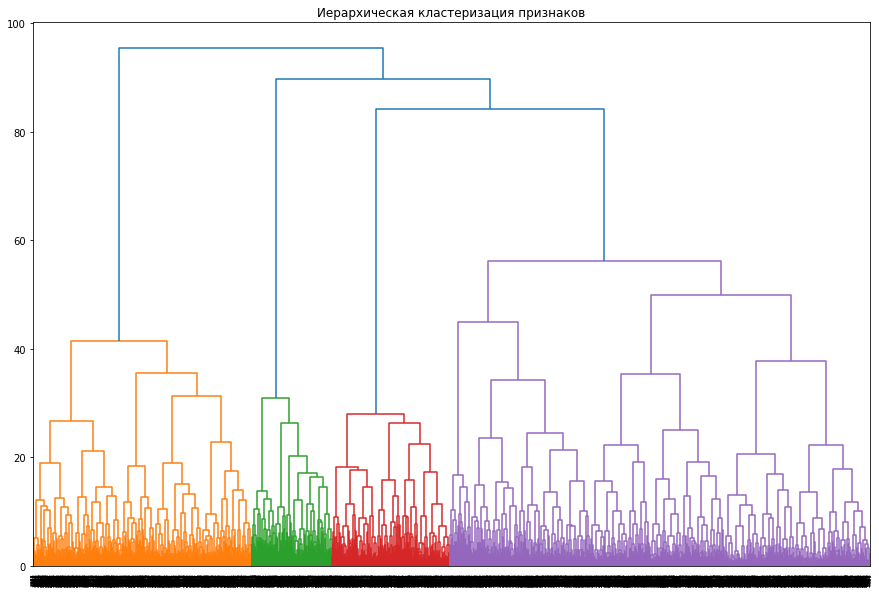

In [21]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков')
plt.show() 

Считаю правильным выделить 6 кластеров.... НО! Договоримся за число кластеров принять n=5...

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [22]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [23]:
# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = labels
gym.groupby(['cluster']).mean().transpose() # средние значения в кластерах

cluster,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
month_to_end_contract,2.85,6.99,2.65,4.17,4.47


Можно предположить что ключевыми признаками разбиения стали 
* near_location, 
* promo_friends, 
* phone, 
* contract_period, 
* group_visits. 
* и как раз 6 кластер = month_to_end_contract... 	

In [24]:
gym.cluster.value_counts() # количественное разбиение на кластеры

2    1132
1    1050
3     871
0     561
4     386
Name: cluster, dtype: int64

Для каждого полученного кластера посчитаем долю оттока. 

In [25]:
# расчет доли оттока в каждом кластере
gym.query('churn==1').groupby('cluster')['churn'].count() / gym.query('churn==1')['churn'].count()

cluster
0   0.21
1   0.12
2   0.41
3   0.16
4   0.10
Name: churn, dtype: float64

Для более наглядного разделения требуется построить распределение для каждого признака по кластерам.

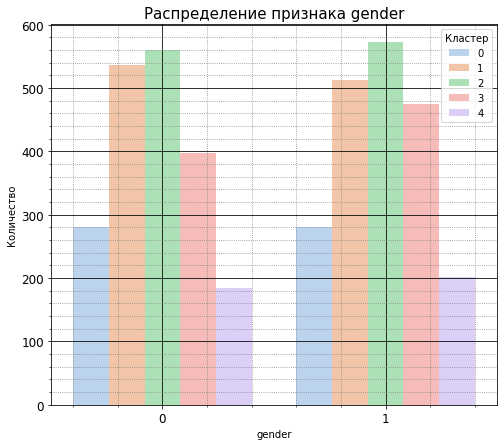

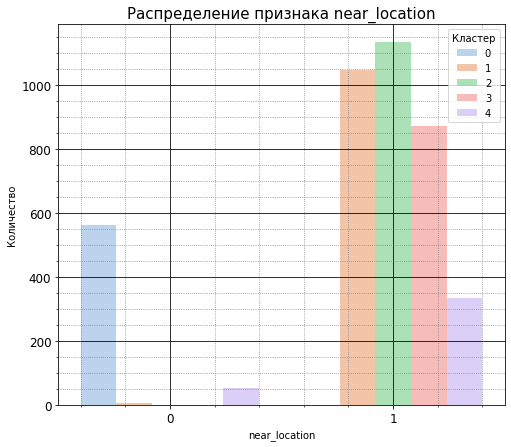

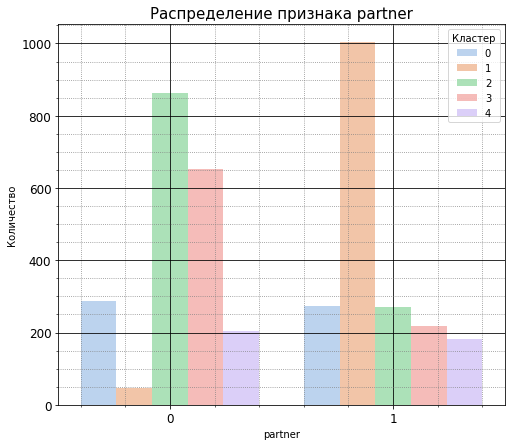

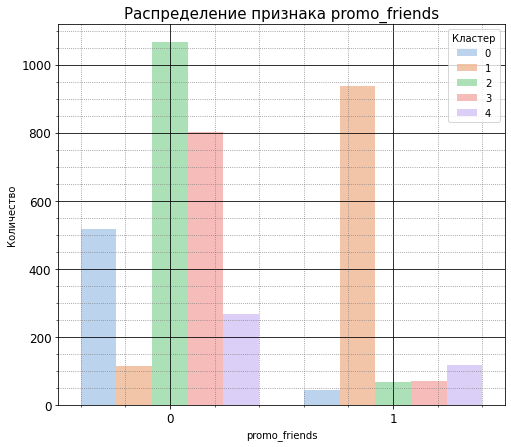

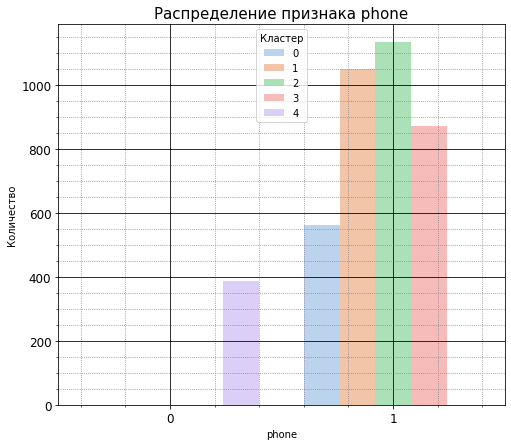

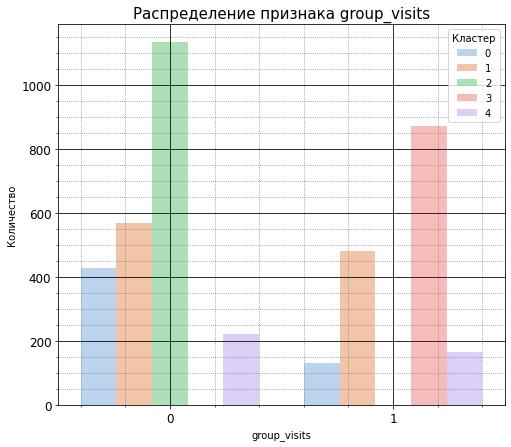

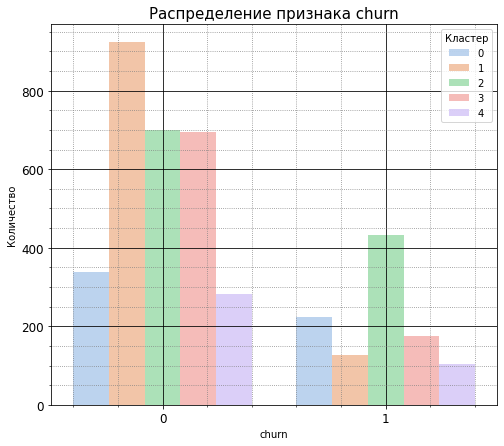

In [26]:
# разделяем датасет на бинарные признаки и признаки с бОльшим количеством переменных
for feature in gym.drop('cluster', axis =1): 
    if gym[feature].nunique() < 3:
        plt.figure(figsize=(8,7)) # строим график
        sns.countplot(data = gym, x = gym[feature], hue = 'cluster',palette="pastel", alpha=0.8) 
        plt.ylabel('Количество')
        plt.xlabel(feature)
        plt.title('Распределение признака ' + feature,fontsize=15)
        plt.grid(which='major',color = 'k')
        plt.minorticks_on()
        plt.grid(which='minor',color = 'gray',linestyle = ':')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Кластер')
        plt.show()

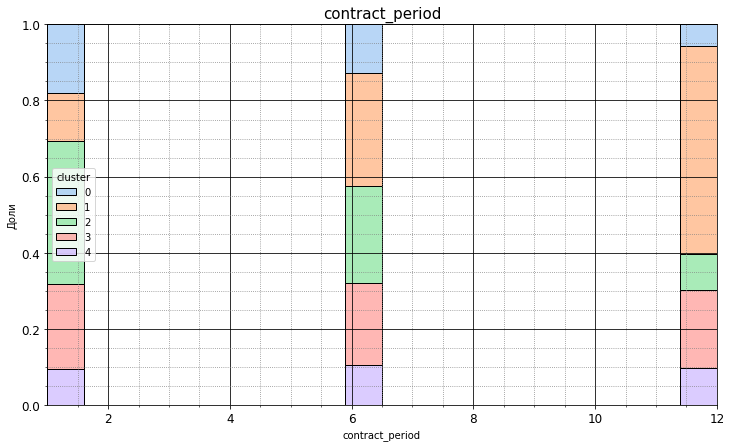

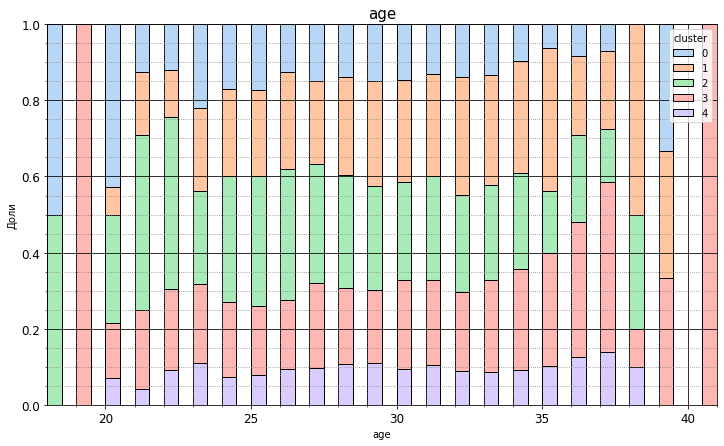

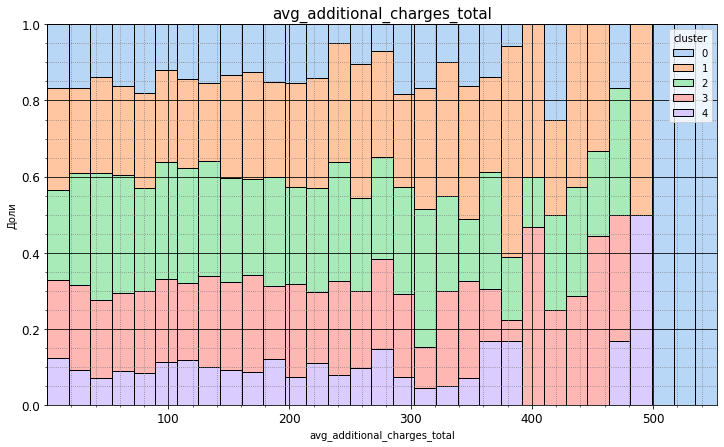

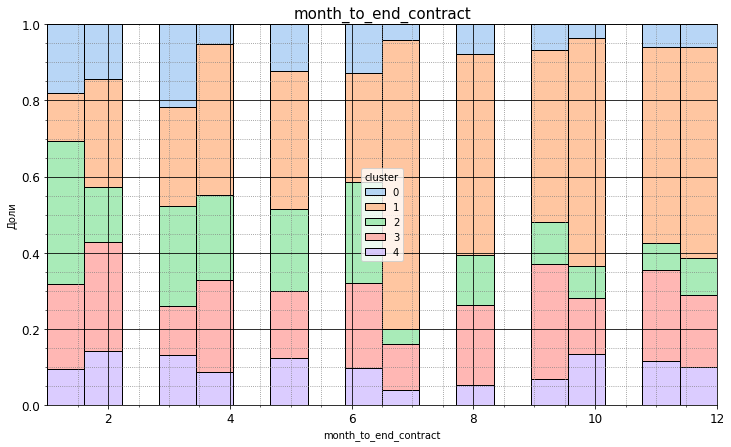

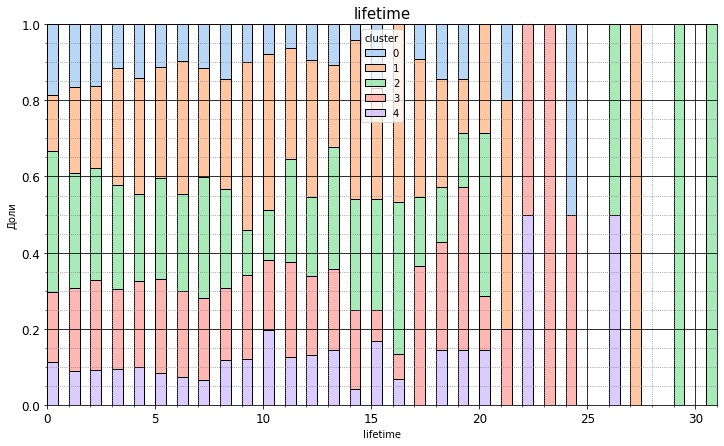

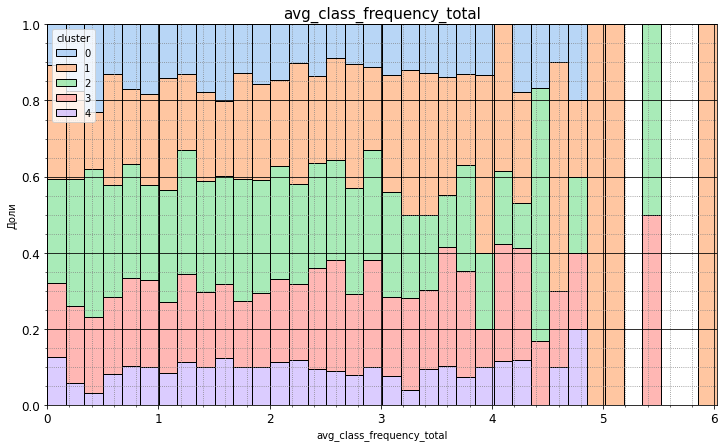

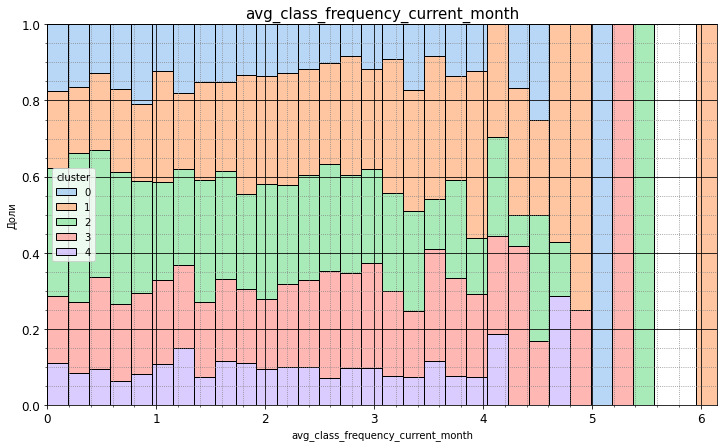

In [27]:
for feature in gym.drop('cluster', axis =1):
    if gym[feature].nunique() > 2:
        plt.figure(figsize=(12,7))
        sns.histplot(data=gym, x = gym[feature], hue = 'cluster', multiple="fill",palette="pastel", cbar= True)
        plt.ylabel('Доли')
        plt.grid(which='major',color = 'k')
        plt.minorticks_on()
        plt.grid(which='minor',color = 'gray',linestyle = ':')
        plt.xlabel(feature)
        plt.title(feature,fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    plt.show()  

### Предварительный вывод

По визуальному распредлению признаков в кластерах можно предварительно говорить о следующем:

- пол - почти равное количественное распредление , но в 3тьем кластере мужчин больше чем женщин
- near_location - один из ключевых признаков, поэтому не удивительно что почти все из 0 кластера и чуть из 4го живут далеко. из 1,2,3 - живут близко.
- partner — распредление 4 и 0 кластеров почти одинаковое, почти все кто попал в 1ый кластер - сотрудник компании-партнёра клуба, а во 2ом и 3 - нет. 
- promo_friends - ещё один ключевой признак. наличие этого признака очень характерно для 1го кластера, а для 0,2 и 3 - его отсутвие
- phone - Все те кто не осталивили телеыфон при регистрации попали в 4ый кластер, все остальные отдельно в других.
- group_visits - если вы попали в кластер №2, то вы точно любитель индивидуальных занятий, зато в 3тьем - только групповые посещения
- churn -... наверное самый опасный для оттока = 2ой кластер ...ну и 3тий, зато 1ый - самый надежный.
- contract_period — в первом кластере самые долгоживущие аббонементы (вот где надежность), во втором и нулевом- чаще покупают что бы попробовать.. остальное распределение почти равное
- age - интересное распределение..в 4ый кластер не вошли ни самые молодые, ни самые возрастные клиенты ...
- avg_additional_charges_total - если клиент в 0 кластере, то скорее всего он из тех кто приносит больше всего выручки
- month_to_end_contract — почти то же что и в contract_period, 1ый кластер опредлеяет "долгоживущих" клиентов, если клиент из 0 или 2 , то скорее всего контракт скоро заканчивается
- lifetime — явно выраженая сегментация после почти 2х лет.. оказывается не всё так просто..во 2ом кластере те кто дольше всего занимается в клубе в том числе..может для их удержания нужно придумать что то новое? супер скидку на годовой аббонемент ?? 
- avg_class_frequency_total — но мы можем быть почти уверены в том что в 1ом кластере занимаются люди сильно увлеченные спортом... по 5-6 раз в неделю
- avg_class_frequency_current_month — как и предыдущий график - 4ый кластер - это про посещения скорее 1-2 , ну может 3 раза в неделю 

Самая высокая доля оттока опредлена в 4ом кластере (41%), минимальная доля - в 4ом (10%). В остальных колебание доли оттока в пределах 12-21 %

## Вывод
- Проанализированы полученные данные по анкетам 4000 клиентов фитнес центра 
- Исходная информация подготовлена для анализа
- Дубликатов и пробелов в данных не выявлено
- Скорректированы названия столбцов в датасете


Определено и представлено в табличном и графическом виде:

    Таблица числовых характеристик признаков (max/ min / средние значения, процентили )
    Матрица корреляции признаков (выделены 2 пары слишком сильно коррелирующих и мешающих ML признаков)
    Таблица средних значений признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
    Графики распределения всех признаков среди для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
    Построена модель прогнозирования оттока клиентов, по целевому признаку — факту оттока клиента в следующем месяце
    Модели обучены двумя способами:
    - LogisticRegression
    - RandomForestClassifier
    Проведена кластеризация клиентов 
    Построена дендрограмма кластеров
    Обучена модель кластеризации на основании алгоритма K-Means 
    

Результаты обучения моделей :
 
* Модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC_AUC.


Опредлены медианные показатели  пользователей:

* гедерное распределение почти равное
* большинство живут поблизости 
* половина клиентов - сотрудники компаний-партнеров
* около 30% клиентов приходят по промо-акциям
* поччти все оставляют контактные телефоны при регистрации
* 50% заключают контракт на 1 месяц, осташиеся - 25% на год и 25%  на 6 месяцев, соответвенно в тех же пропорциях и срок до докончания контракта 
* чуть меньше половины посещают групповые занятия
* возрст -  от 18 до 41 года, в среднем около 30лет
* на дополнительные услуги в месяц тратят в основном до 200 тугриков
* но больше половины с клубом уже больше квартала, это хорошо, значит продлевают месячные абонементы. Макимальное значение - 31 месяц... это почти 3 года постоянных отношений...
* средняя частота посещений за предыдущий месяц и за всё время посещений - почти одинакова - редко больше 2,5 раз в недлею... те колеблется от 2 до 3 раз в неделю.. хороший уровень.

* около трети клиентов фитнес-центра уходит в отток.

Сформированы несколько наиболее ярких групп/кластеров:
- кластер 0:
    * клиент проживает на значительном расстоянии от клуба (является характерным признаком)
    * запись в клуб проходит в основном без использования промо-акций
    * при оформлении предоставляет контактный номер 
    * скорее всего не посещает групповые занятия
    * покупка аббонемента на год маловероятна
    * но при этом скорее всего тратит больше остальных на длополнительные услуги
    * редко посещает клуб чаще 4 раз в неделю
    * доля оттока 21% (2ое место из 5)
    
    
- кластер 1
    * клиент проживает близко от клуба  
    * почти гарантировано является сотрудником компании-партнёра клуба (можно сказать что это является  характерным признаком)
    * запись в клуб почти всегда проходила через промо-акцию 
    * при оформлении предоставляет контактный номер
    * посещение групповых или индивидуальных занятий равновероятно
    * **с 88% вероятностью не попадёт в отток в следующем месяце**
    * покупка аббонемента на 1 месяц маловероятна
    * может посещать клуб часто и если продлит контаркт то скорее ещё на 6 или 12 месяцев.
    * доля оттока 12% (4тье место из 5)


- кластер 2
    * самая многочисленная группа
    * клиент проживает близко от клуба  
    * не обязательно является сотрудником компании-партнёра клуба 
    * запись в клуб почти гаратнировано проходила без использования промо-акций 
    * при оформлении предоставляет контактный номер 
    * не посещает групповые занятия  (можно сказать что это является характерным признаком)
    * **с 59% вероятностью перестанет ходить в следующем месяце**
    * покупка аббонемента на год маловероятна   
    * скорее всего контаркт заканчивается меньше чем через полгода
    * в этом сегменте есть те кто дольше всего занимается в клубе
    * доля оттока 41% (1ое место из 5)
    
    
 - кластер 3
    * клиент проживает близко от клуба    
    * не обязательно является сотрудником компании-партнёра клуба  
    * запись в клуб почти гарантировано проходила без использования промо-акций 
    * при оформлении предоставляет контактный номер 
    * всегда посещает групповые занятия  (можно сказать что это является  характерным признаком)
    * равное распредление действующих аббонементов на месяц/полгода/год
    * равное распредление времени до окончания действующих аббонементов
    * возможно тратит выше общей средней суммы на дополнительные услуги
    * доля оттока 16% (2ое место из 5)
    
 
 - кластер 4   
    * самая малочисленная группа
    * клиент почти всегда проживает близко от клуба
    * равновероятно является сотрудником компании-партнёра клуба или другой компании
    * запись в клуб чаще проходила без использования промо-акций 
    * при оформлении не предоставляет контактный номер (можно сказать что это является  характерным признаком)
    * посещение групповых или индивидуальных занятий равновероятно
    * **с 90% вероятностью не попадёт в отток в следующем месяце**
    * равное распредление действующих аббонементов на месяц/полгода/год 
    * равное распредление времени до окончания действующих аббонементов
    * доля оттока 10% (5тое место из 5)
    
    
Определены взаимосвязи  кто ушёл (отток):
* ушедшие в отток клиенты в большей степени не являются сотрудниками компаний-партнёров и не приходили по промо-акциям (почти все по этим признакам (partner и promo-friends) в 1 кластере, а их отток всего 12%).

* Так же ушедшие в отток в большей части не посещали групповые занятия и были одни из самых постоянных живущих клиентов


## Рекомендации

1. Расчитать возможность предоставления скидок для аббонементов длительностью на 6 или 12 месяцев
2. Расчитать возможность введения абонементов на 3 месяца / 9 месяцев
3. Предоставлять бесплатные дополнительные услуги (соразмерно длительности аббонемента) при покупке контракта более чем на 1 месяц
4. При покупке второго (или более ?) контаркта на 6 месяцев или год предоставлять соразмерные дополнительные бонусы / скидки / бесплатные услуги. Долгосрочная лояльность должна быть вознаграждена
5. Рассмотреть возможность предоставления скидок на первый конракт за переход из другого фитнес центра
6. Рассчитать возможность снижения стоимости первого контракта на 6 месяцев / год по промо-акциям и/или для сотрудников компании партнёра
7. Рассчитать возможность увеличиения количества компаний-партнеров 
8. При снижении частоты посещений (или при приблежении окончания срока контракта) - предложить одно или несколько бесплатных групповых занятий 